# Transfer Learning
Transfer learning reuses a pre-trained model to make predictions on a new dataset. We use the model's pre-trained feature extractor (convolutional base) and **re-train a new classifier** to learn new weights for the new dataset. Specifically, **we "freeze" the layers in the feature extractor**. The pre-trained feature extractor has learned valuable features for detecting many different object types. We assume such features are general enough that we only need to re-train the classifier portion of the network.

This approach requires much less data and computational resources than training from scratch.

# Fine Tuning
It's very similar to Transfer Learning. Instead of freezing the feature extractor completely, we load the feature extractor and then **freeze the first several layers of the feature extractor** but allow the last few layers to be trained further. The first several layers in the feature extractor represent generic, low-level features (e.g., edges, corners, and arcs) that are fundamental building blocks necessary to support many classification tasks. Subsequent layers in the feature extractor build upon the lower-level features to learn more complex representations that are more closely related to the content of a particular dataset.

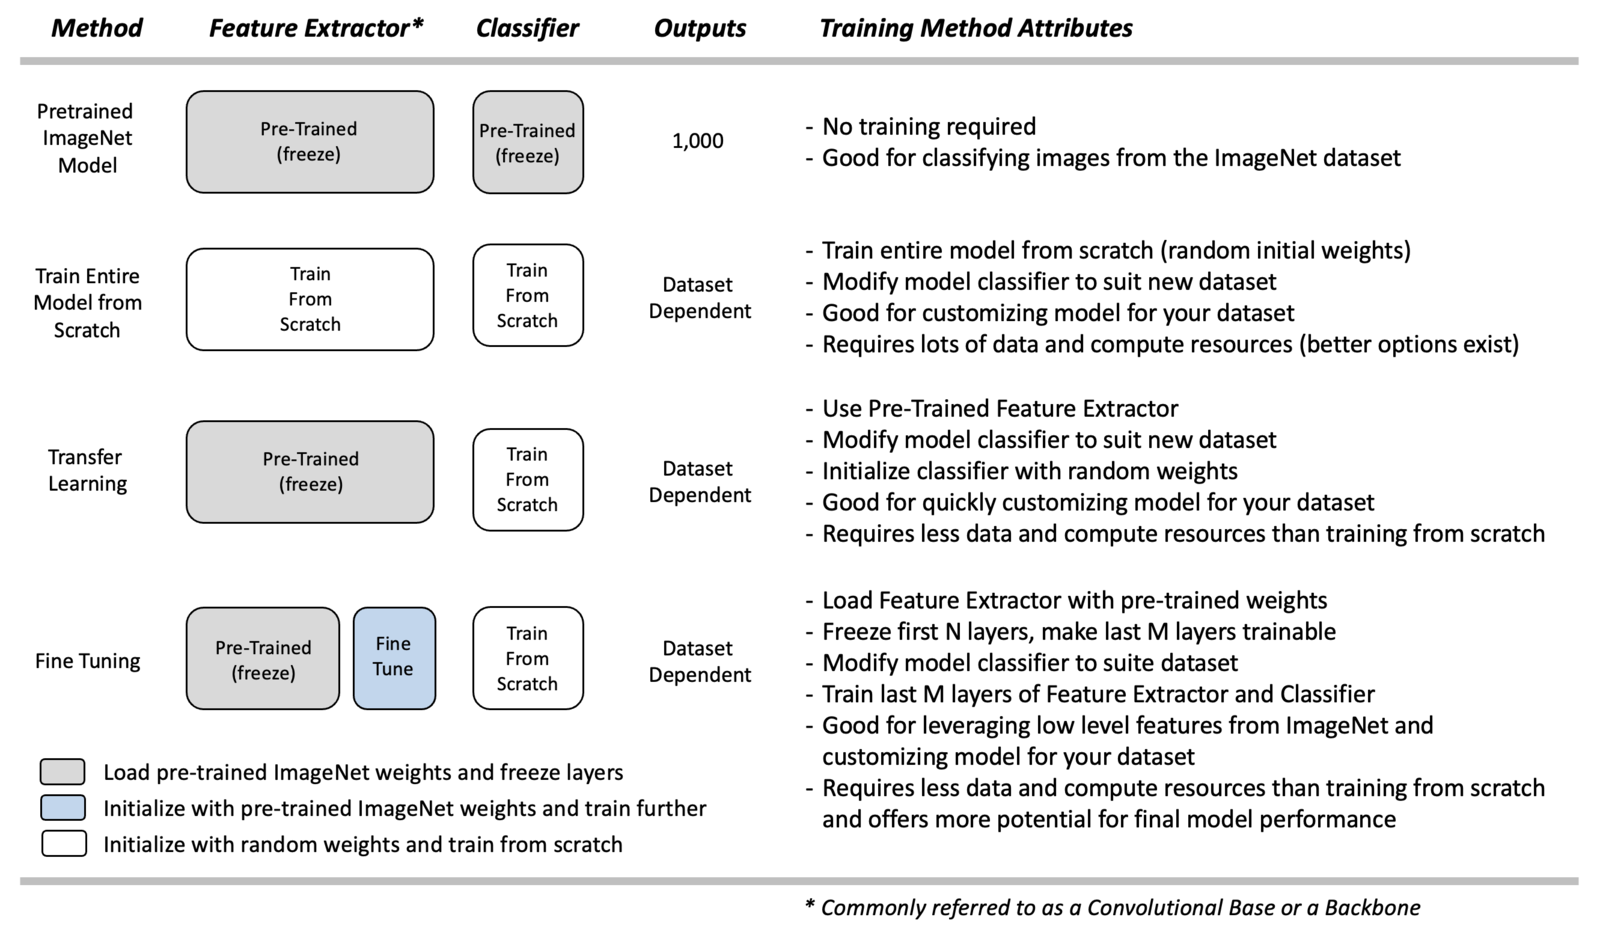

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras.utils import image_dataset_from_directory

import os
import pathlib
import random
import requests
import glob as glob
from zipfile import ZipFile
from urllib.request import urlretrieve
from dataclasses import dataclass

In [2]:
SEED_VALUE = 647

random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

# 1. Download the Dataset

We will use the German Traffic Sign Recognition Benchmark [GTSRB](https://www.kaggle.com/datasets/meowmeowmeowmeowmeow/gtsrb-german-traffic-sign), a well-known classification dataset that contains German traffic signs from 43 classes. The entire dataset (train and test) contains over 50,000 images. The training set alone contains over 39,000 images.

We will use a small version of the GTSRB dataset, which contains just 40 images per class, to demonstrate how to leverage pre-trained models for cases when we may have a limited-size dataset.

In [3]:
def download_and_unzip(url, save_path):

    # downloading zip file using urllib package
    urlretrieve(url, save_path)

    # extracting zip file using the zipfile package
    with ZipFile(save_path) as z:

        # extract ZIP file contents in the same directory
        z.extractall(os.path.split(save_path)[0])

In [4]:
URL = r'https://www.dropbox.com/s/uzgh5g2bnz40o13/dataset_traffic_signs_40_samples_per_class.zip?dl=1'

# current directory
curr_dir = os.getcwd()

dataset_path   = os.path.join(curr_dir, 'dataset_traffic_signs_40_samples_per_class')
zip_path = os.path.join(curr_dir, 'dataset_traffic_signs_40_samples_per_class.zip')

download_and_unzip(URL, zip_path)

# 2. Dataset and Training Configuration

In [5]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 43
    IMG_HEIGHT:  int = 224
    IMG_WIDTH:   int = 224
    CHANNELS:    int = 3

    DATA_ROOT_TRAIN:  str = os.path.join(dataset_path, 'Train')
    DATA_ROOT_VALID:  str = os.path.join(dataset_path, 'Valid')
    DATA_ROOT_TEST:   str = os.path.join(dataset_path, 'Test')
    DATA_TEST_GT:     str = os.path.join(dataset_path, 'Test.csv')


@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:       int   = 32
    EPOCHS:           int   = 101
    LEARNING_RATE:    float = 0.0001
    DROPOUT:          float = 0.6
    LAYERS_FINE_TUNE: int   = 8

# 3. Create Train and Validation Sets

We use `image_dataset_from_directory()`, a utility in Keras for creating an image dataset.

In [6]:
train_ds = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_TRAIN, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True, seed=SEED_VALUE,
                                        label_mode='int', # use integer encoding
                                        image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH))

val_ds = image_dataset_from_directory(directory=DatasetConfig.DATA_ROOT_VALID, batch_size=TrainingConfig.BATCH_SIZE, shuffle=True, seed=SEED_VALUE,
                                      label_mode='int', # use integer encoding
                                      image_size=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH))

Found 1204 files belonging to 43 classes.
Found 516 files belonging to 43 classes.


In [7]:
# display the class names from the training dataset.
class_names = train_ds.class_names
print(class_names)

['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '5', '6', '7', '8', '9']


Notice that the inferred class names are in an alpha-numeric sequence as opposed to numeric order.

## 3.1 Display Sample Images from the Training Set

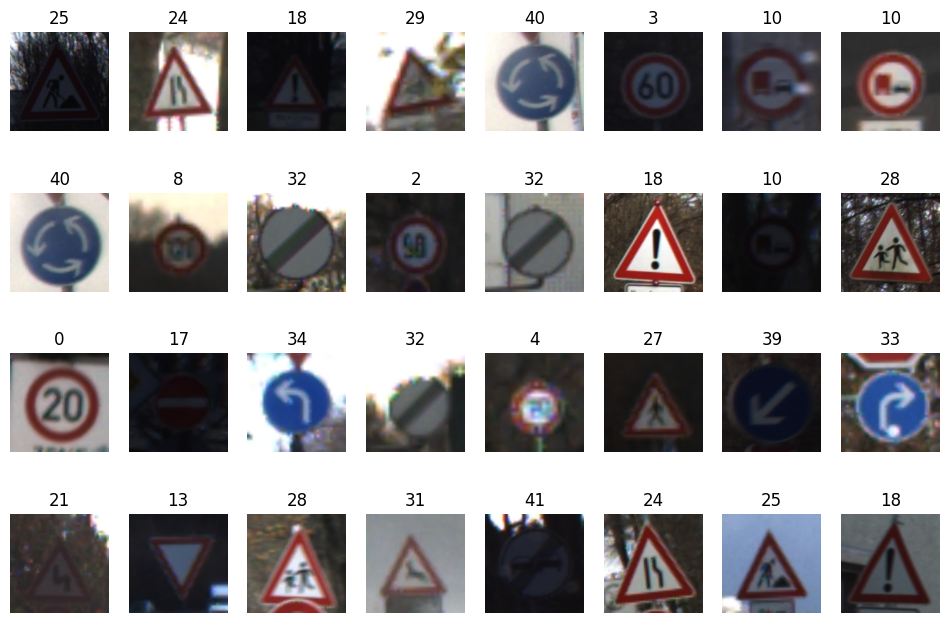

In [8]:
# view sample images from the training set

plt.figure(figsize=(12, 8))
num_rows, nums_columns = 4, 8

# use the `take()` method to retrieve the first batch of data from the training dataset
for image_batch, labels_batch in train_ds.take(1):
     # plot each image
    for i in range(num_rows * nums_columns):
        ax = plt.subplot(num_rows, nums_columns, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        label = labels_batch[i].numpy()
        plt.title(class_names[label])
        plt.axis('off');

# 4. Create the Test Dataset

The images and labels for the test dataset are stored differently from the training set.

The images for the test set are stored in a folder called `Test` while the ground truth labels for the test dataset are listed in a csv file called `Test.csv`.

In [9]:
# load test ground truth labels

input_file = DatasetConfig.DATA_TEST_GT
df = pd.read_csv(input_file)
df.head(5)

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


In [10]:
test_labels = df['ClassId'].values.tolist()
print('Total number of test samples:', len(test_labels))

Total number of test samples: 12630


## 4.1 Convert the Test Labels

Since the class names in the training and validation sets are in an alpha-numeric order, we need to map the test class names to the right one.

In [11]:
# convert train/validation class names to integers
class_names_int = list(map(int, train_ds.class_names))

# create a dictionary mapping ground truth IDs to class name IDs
gtid_2_cnidx = dict(zip(class_names_int, range(0, DatasetConfig.NUM_CLASSES)))

gtid_2_cnidx.items()

dict_items([(0, 0), (1, 1), (10, 2), (11, 3), (12, 4), (13, 5), (14, 6), (15, 7), (16, 8), (17, 9), (18, 10), (19, 11), (2, 12), (20, 13), (21, 14), (22, 15), (23, 16), (24, 17), (25, 18), (26, 19), (27, 20), (28, 21), (29, 22), (3, 23), (30, 24), (31, 25), (32, 26), (33, 27), (34, 28), (35, 29), (36, 30), (37, 31), (38, 32), (39, 33), (4, 34), (40, 35), (41, 36), (42, 37), (5, 38), (6, 39), (7, 40), (8, 41), (9, 42)])

In [12]:
# convert the test labels to the labels that correctly map to the same classes in the train and validation sets

converted_test_labels = [gtid_2_cnidx[x] for x in test_labels]
print('Original test labels:', test_labels[:5])
print('Converted test labels:', converted_test_labels[:5])

Original test labels: [16, 1, 38, 33, 11]
Converted test labels: [8, 1, 32, 27, 3]


## 4.2 Get the File Paths for the Test Images

In [13]:
# create image path names for the test images

test_image_paths = sorted(glob.glob(DatasetConfig.DATA_ROOT_TEST + os.sep + '*.png'))
print('Total test images:', len(test_image_paths))

Total test images: 12630


## 4.3 Combine Images and Labels to Create the Test Set

We use `from_tensor_slices()` to combine the image paths and image labels in a `tf.data.dataset`.

In [14]:
test_ds = tf.data.Dataset.from_tensor_slices((test_image_paths, converted_test_labels))

## 4.4 Load and Pre-process the Test Images

In [15]:
def process_image(image_path, label):

    # read the image using TensorFlow
    image = tf.io.read_file(image_path)

    # decode the above `tf_image` from a Bytes string to a numeric Tensor
    decoded_image = tf.image.decode_png(image, channels=3)

    # resize the image
    image_resized = tf.image.resize(decoded_image, [DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH])

    return image_resized, label

In [16]:
# apply the `process_image` function to the test set
test_set = test_ds.map(process_image)

# set the batch size for the test set
test_set = test_set.batch(TrainingConfig.BATCH_SIZE)

## 4.5 Display Sample Images from the Test Set

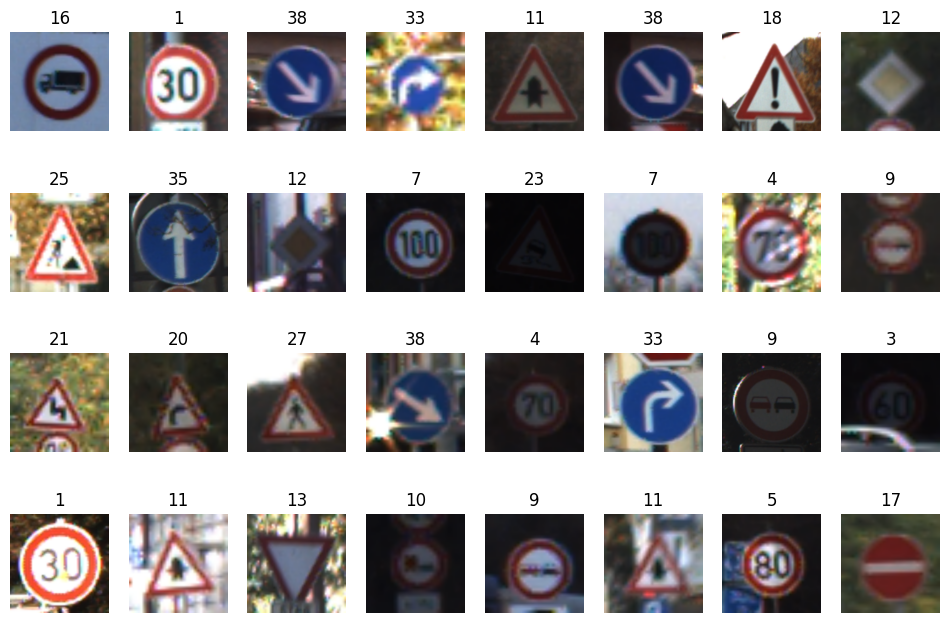

In [17]:
# view sample images from the test set

plt.figure(figsize=(12, 8))
num_rows, nums_columns = 4, 8

# use the `take()` method to retrieve the first batch of data from the test dataset
for image_batch, labels_batch in test_set.take(1):
     # plot each image
    for i in range(num_rows * nums_columns):
        ax = plt.subplot(num_rows, nums_columns, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        label = labels_batch[i].numpy()
        plt.title(class_names[label])
        plt.axis('off');

# 5. Modeling VGG-16 for Fine Tuning

To configure the model for Fine-Tuning, we will load the model's convolutional base with weights that were learned from the ImageNet dataset. Since we need to redefine the classifier, we will load the model without a classifier (`include_top=False`), so we can specify our own classifier for the dataset.

In [18]:
input_shape = (DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS)
print('input shape:', input_shape)

input shape: (224, 224, 3)


## 5.1 Load the VGG-16 Convolutional Base

In [19]:
vgg16_conv_base = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape=input_shape)
vgg16_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 5.2 Freeze the Initial Layers in the Convolutional Base

We need to lock down the initial layers so that only the last few layers (`TrainingConfig.LAYERS_FINE_TUNE = 8`) are trainable. There are two ways to specify which layers in the model are trainable (tunable):

1. We can start by making the entire convolutional base trainable by setting the trainable flag to `True`. Then loop over the initial layers and make them untrainable by setting the same trainable flag for each layer to `False`.

2. We can freeze the entire convolutional base by setting the trainable flag to `False`, and then loop over the last few layers and set the trainable flag to `True`.

We use the first approach. We start by setting the entire convolutional base as "trainable" by setting the trainable attribute to `True`.

In [20]:
# set all layers in the convolutional base to trainable (will FREEZE initial layers further below)
vgg16_conv_base.trainable = True

# specify the number of layers to fine tune at the end of the convolutional base
num_layers = len(vgg16_conv_base.layers)
num_layers_fine_tune = TrainingConfig.LAYERS_FINE_TUNE
print('total number of layers:', num_layers)
print('number of layers for fine-tuning:', num_layers_fine_tune)

total number of layers: 19
number of layers for fine-tuning: 8


In [21]:
# freeze the initial layers in the convolutional base
for layer in vgg16_conv_base.layers[ : num_layers-num_layers_fine_tune]:
    print('freeze layer:', layer)
    layer.trainable = False

print()
print('Configured to fine tune the last {} convolutional layers'.format(num_layers_fine_tune))

freeze layer: <keras.src.engine.input_layer.InputLayer object at 0x78a4d4354730>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a460119ba0>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a460167fa0>
freeze layer: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78a456f10c40>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a456f113c0>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a456f11b10>
freeze layer: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78a456f130a0>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a456f12950>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a456f13a00>
freeze layer: <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78a456f13a90>
freeze layer: <keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x78a456f458d0>

Configured to fine tune the last 8 co

In [22]:
vgg16_conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## 5.3 Add the Classifier to Complete the Model

Since we intend to train and use the model to classify traffic signs (43 classes), we will need to add our own classification layer.

We will use just a single fully connected dense layer that contains 128 nodes, followed by a softmax output layer that contains 43 nodes for each of the 43 classes.

The number of dense layers and the number of nodes per layer is a design choice, but the number of nodes in the output layer must match the number of classes in the dataset.

Since we are working with a very small dataset (40 samples per class), the model will be prone to overfitting, so we will add a dropout layer in the classifier.

In [23]:
inputs = tf.keras.Input(shape=input_shape)

x = tf.keras.applications.vgg16.preprocess_input(inputs)

x = vgg16_conv_base(x)

# flatten the output from the convolutional base
x = layers.Flatten()(x)

# Add the classifier.
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(TrainingConfig.DROPOUT)(x)

# output layer
outputs = layers.Dense(DatasetConfig.NUM_CLASSES, activation='softmax')(x)

# the final model
model_vgg16_finetune = keras.Model(inputs, outputs)

model_vgg16_finetune.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               321139

## 5.4 Compile and Train the Model

Here we use `SparseCategoricalCrossentropy` since we are using integer-encoded labels.

For one-hot encoded labels, the appropriate loss function would be `CategoricalCrossentropy`.

Since we included a Softmax layer in the model output, we specify `from_logits=False`.

Alternatively, we can remove the softmax layer in the model and set `from_logits=True`, and the loss function will apply the softmax function internally. The results should be identical.

In [24]:
# compile the model

model_vgg16_finetune.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=["accuracy"])

In [25]:
# train the model

history = model_vgg16_finetune.fit(train_ds, epochs=TrainingConfig.EPOCHS, validation_data=val_ds)

Epoch 1/101
38/38 [==============================] - 31s 457ms/step - loss: 4.6596 - accuracy: 0.0199 - val_loss: 3.7518 - val_accuracy: 0.0388
Epoch 2/101
38/38 [==============================] - 10s 245ms/step - loss: 3.7683 - accuracy: 0.0349 - val_loss: 3.7462 - val_accuracy: 0.0465
Epoch 3/101
38/38 [==============================] - 10s 248ms/step - loss: 3.7345 - accuracy: 0.0357 - val_loss: 3.7047 - val_accuracy: 0.0601
Epoch 4/101
38/38 [==============================] - 10s 254ms/step - loss: 3.6531 - accuracy: 0.0532 - val_loss: 3.4768 - val_accuracy: 0.1279
Epoch 5/101
38/38 [==============================] - 10s 250ms/step - loss: 3.4165 - accuracy: 0.1321 - val_loss: 3.1846 - val_accuracy: 0.1899
Epoch 6/101
38/38 [==============================] - 10s 250ms/step - loss: 3.0862 - accuracy: 0.1844 - val_loss: 2.8172 - val_accuracy: 0.2868
Epoch 7/101
38/38 [==============================] - 10s 258ms/step - loss: 2.6535 - accuracy: 0.2973 - val_loss: 2.5842 - val_accuracy:

## 5.5 Plot the Training History

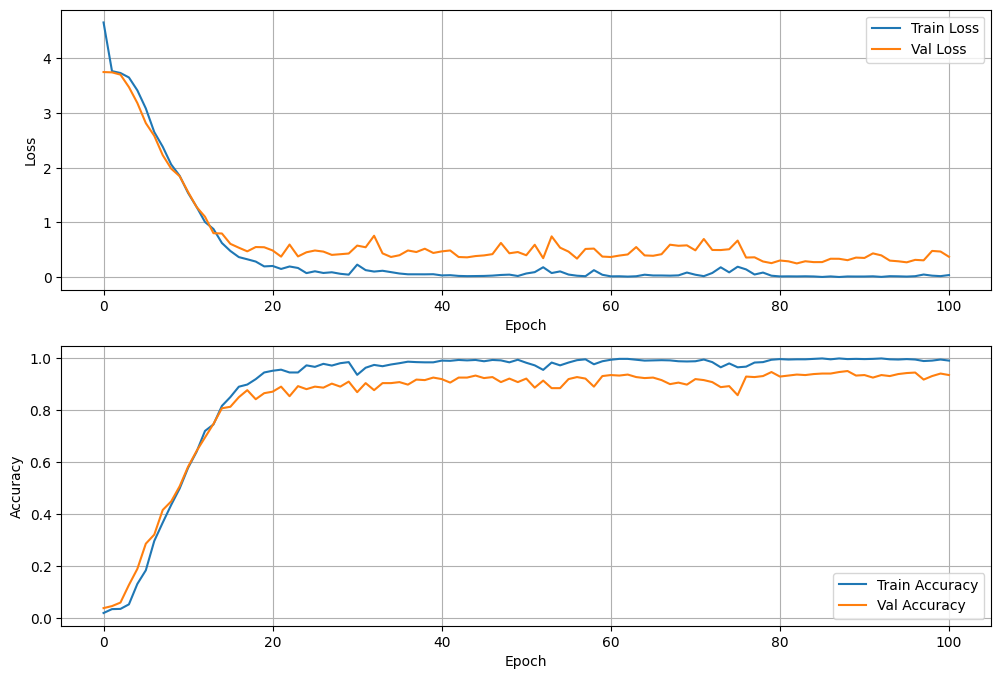

In [26]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'], loc='upper right')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train Accuracy', 'Val Accuracy'], loc='lower right')
plt.grid(True);

The plots shows that a rapid decrease in loss and increase in accuracy, which can be attributed to the model being initialized with pre-trained weights. The plots indicate that the model has learned to generalize well to unseen data.

# 6. Model Evaluation

In [27]:
# evaluate on the validation set

val_loss, val_acc = model_vgg16_finetune.evaluate(val_ds, verbose=0)
print('validation loss:', val_loss)
print('validation accuracy', val_acc)

validation loss: 0.3707144558429718
validation accuracy 0.9360465407371521


In [28]:
# evaluate on the test set

test_loss, test_acc = model_vgg16_finetune.evaluate(test_set, verbose=0)
print('test loss:', test_loss)
print('test accuracy', test_acc)

test loss: 0.3691037893295288
test accuracy 0.9371337890625


## 6.1 Display Sample Test Results

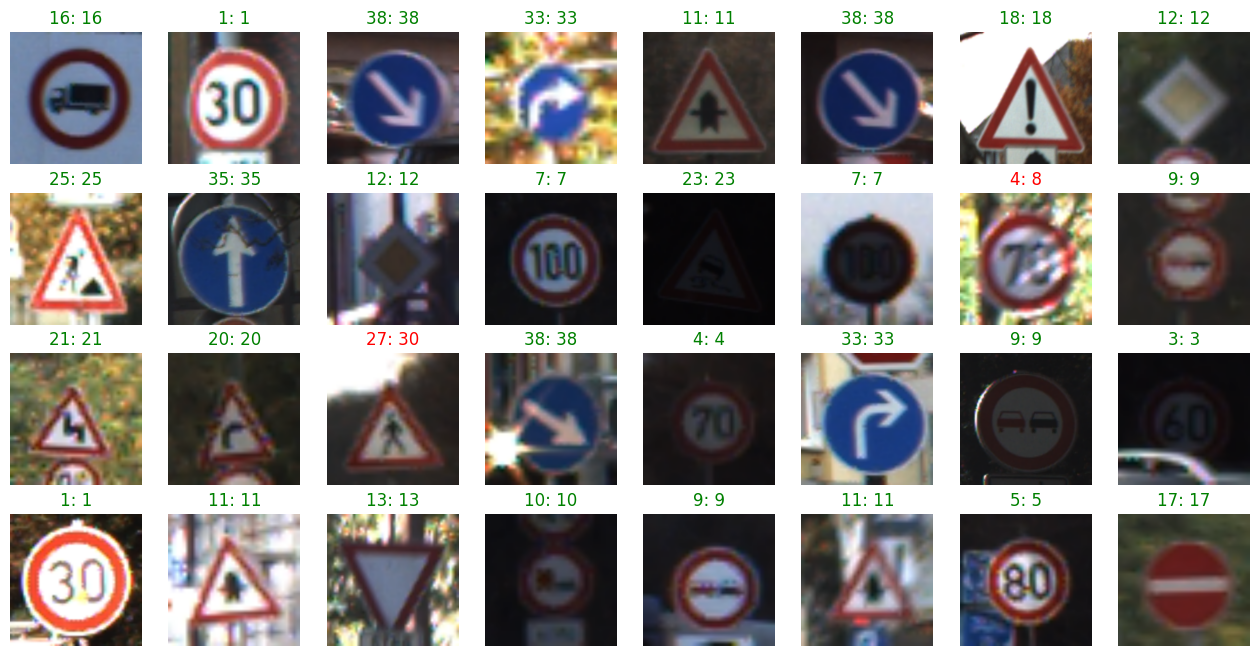

In [29]:
# visualize the prediction results of test set

plt.figure(figsize=(16, 8))
num_rows, nums_columns = 4, 8

# retrieve the first batch of data from the test dataset
for image_batch, labels_batch in test_set.take(1):

  # predict
  preds = model_vgg16_finetune.predict(image_batch, verbose=0)

  for i in range(len(labels_batch)):
    true_label = labels_batch[i].numpy()
    pred_label = tf.argmax(preds[i]).numpy()

    if true_label == pred_label:
      color = 'green'
    else:
      color = 'red'

    title = '{}: {}'.format(class_names[true_label], class_names[pred_label])

    # plot the image
    ax = plt.subplot(num_rows, nums_columns, i + 1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(title, color=color)
    plt.axis('off');
